# Unsupervised Image Classification and Generation with PCA and K-Means

### By David Krajewski and Micah Reich

----------------------------------------------------------------------------------------------------------------------

**Abstract**: Image classification and image generation are long-standing problems in the fields of artificial intelligence and computer science research. While many modern approaches to these tasks make use of deep neural networks like Generative Adversarial Networks and Convolutional Neural Networks, we demonstrate that simple image recognition and generation may be accomplished with classical, unsupervised methods in linear algebra, including Principal Component Analysis and K-means clustering.

----------------------------------------------------------------------------------------------------------------------

### Load in packages that we will use

In [412]:
using MLDatasets, LinearAlgebra, Clustering, ImageCore, Images, MultivariateStats, StatsBase, Noise, PyPlot #, Plots

### Load in dataset

Training set size: (28, 28, 60000)
Testing set size: (28, 28, 10000)


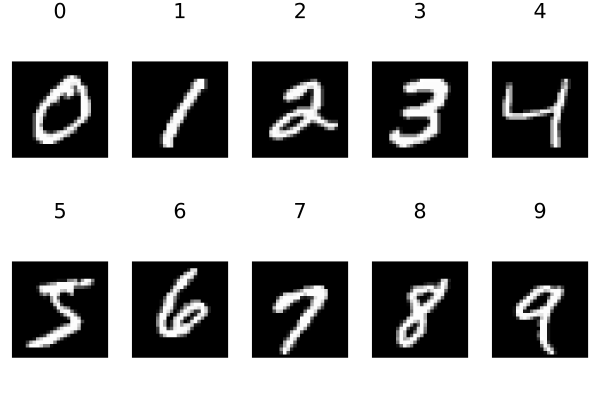

In [244]:
# load full training set
train_x, train_y = MNIST.traindata()

# load full test set
test_x,  test_y  = MNIST.testdata()

println("Training set size: " * string(size(train_x)))
println("Testing set size: " * string(size(test_x)))

p0 = Plots.plot(title = "0", Gray.(transpose(MNIST.traintensor(indexin(0, train_y)[1]))))
p1 = Plots.plot(title = "1", Gray.(transpose(MNIST.traintensor(indexin(1, train_y)[1]))))
p2 = Plots.plot(title = "2", Gray.(transpose(MNIST.traintensor(indexin(2, train_y)[1]))))
p3 = Plots.plot(title = "3", Gray.(transpose(MNIST.traintensor(indexin(3, train_y)[1]))))
p4 = Plots.plot(title = "4", Gray.(transpose(MNIST.traintensor(indexin(4, train_y)[1]))))
p5 = Plots.plot(title = "5", Gray.(transpose(MNIST.traintensor(indexin(5, train_y)[1]))))
p6 = Plots.plot(title = "6", Gray.(transpose(MNIST.traintensor(indexin(6, train_y)[1]))))
p7 = Plots.plot(title = "7", Gray.(transpose(MNIST.traintensor(indexin(7, train_y)[1]))))
p8 = Plots.plot(title = "8", Gray.(transpose(MNIST.traintensor(indexin(8, train_y)[1]))))
p9 = Plots.plot(title = "9", Gray.(transpose(MNIST.traintensor(indexin(9, train_y)[1]))))

Plots.plot(p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, layout=(2, 5), axis=([], false))

### Reformat training data into a matrix of flattened vectors where each column is a single image.

### Then plot an image to ensure it was done correctly

Training set size: (784, 60000)
Testing set size: (784, 10000)


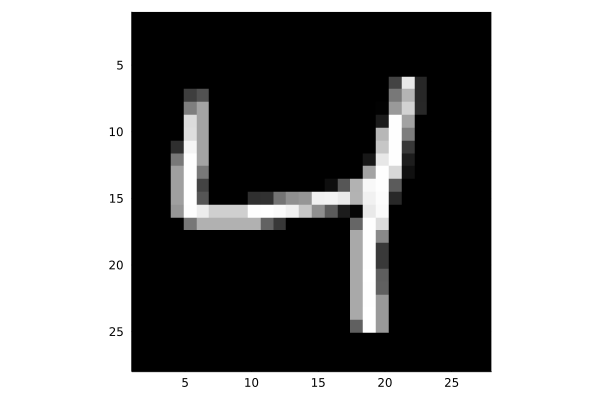

In [245]:
reshaped_train_x = reshape(train_x, (28*28, size(train_x)[3]))
reshaped_test_x = reshape(test_x, (28*28, size(test_x)[3]))

println("Training set size: " * string(size(reshaped_train_x)))
println("Testing set size: " * string(size(reshaped_test_x)))

# make sure we've correctly maintained the data

function reshape_flattened_vector(flat_vector)
    n_rows = 28
    n_cols = 28
    
    # reshape flat vector to 2d image, for some reason img gets
    # flipped along diagonal when reshaping so we transpose it 
    return transpose(reshape(flat_vector, (n_rows, n_cols)))
end

first_ex = reshaped_train_x[:,3]
first_ex_reshaped = reshape_flattened_vector(first_ex)

# show a few of the images to be sure
Plots.plot(Gray.(first_ex_reshaped))

### This method will give us all the images for a given digit

### For example, this is useful when we want to pull all the images containing 4's, etc.

In [397]:
# get images of a certain class
function get_mnist_digitclass(digitclass, data, labels)
    digitclass_vec = Array{Float64}(undef, 0, size(data)[1])
    # print(size(digitclass_vec))
    
    for i = 1:size(data)[2] # number of samples
        if(labels[i] == digitclass)
            digitclass_vec = [ digitclass_vec; transpose(data[:,i]) ]
        end
    end
    
    return transpose(digitclass_vec)
end

get_mnist_digitclass (generic function with 2 methods)

### Use SVD to reduce a random image in our training set

In [22]:
test_svd = svd(MNIST.traintensor(3))
println("Singular values: ", test_svd.S)

Singular values: Float32[5.7440734, 3.463875, 2.7429194, 1.8240672, 1.4560204, 0.66548187, 0.5880818, 0.5685397, 0.31886494, 0.22387388, 0.19487417, 0.047999717, 0.028930705, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 2.6585892f-7, 1.9379394f-13]


### Plot the SVD representation of our digit

4


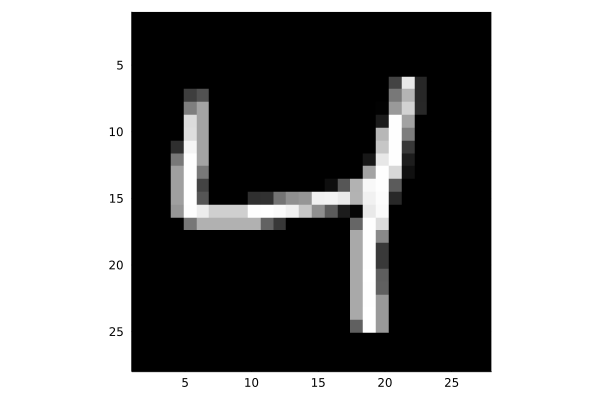

In [8]:
reconstructed_test_svd = transpose((test_svd.U * Diagonal(test_svd.S) * test_svd.Vt))
println(MNIST.trainlabels(3))
Plots.plot(Gray.(reconstructed_test_svd))

### Using "low rank" approximation for images

### We grab the first 3 singular elements from our SVD to show that the digit is still recognizable even with significantly less data

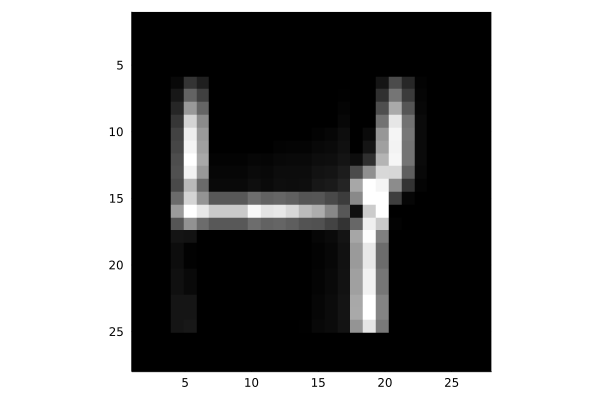

In [9]:
# rank 3 approximation for test_svd
test_svd_3 = transpose(test_svd.U[:, 1:3] * Diagonal(test_svd.S[1:3]) * test_svd.Vt[1:3, :])
Plots.plot(Gray.(test_svd_3))

### Build principal components of MNIST

#### Helper functions that perform the actual PCA training, displaying sample images and displaying the 3D scatter plots of the projections on to the low dimensional subspace

In [279]:
function pca_m(data, n_reduced_dims)
    data = Float64.(data)
    
    pca_model = fit(PCA, data; maxoutdim=n_reduced_dims)
    
    transformed_x = transform(pca_model, data)
    proj_mat = projection(pca_model)
    reconstructed = reconstruct(pca_model, transformed_x)
    
    return (pca_model, reconstructed, proj_mat)
end

function show_sample_img(data, sample_no)
    data_sample = data[:,sample_no]
    data_sample_reshaped = reshape_flattened_vector(data_sample)
    
    return Plots.plot(Gray.(data_sample_reshaped), title=string(sample_no))
end

function display_proj(proj_coords, r_start, r_end, color, label)
    (x1, y1, z1) = (proj_coords[r_start:r_end, 1], 
                    proj_coords[r_start:r_end, 2], 
                    proj_coords[r_start:r_end, 3])
    
    return scatter3D(x1, y1, z1, color = color, label = label, s = 60)
end

function get_digit_projections(data, labels, digit_class)
    for i = 1:size(labels)[1]
        if labels[i] == digit_class
            println(labels[i])
        end
    end
end

get_digit_projections (generic function with 1 method)

### Train the PCA and then project down to subspace, plot in 3D the projections of the fours images and fives images

In [280]:
function least_squares(A, b)
    return inv(transpose(A) * A) * transpose(A) * b
end

function kdim_subspace_proj(basis_matrix, samples)
    # project samples on to k-dimension subspace of best fit spanned by
    # the vectors in the columns of the basis matrix
    proj_matrix = basis_matrix * inv(transpose(basis_matrix)*basis_matrix) * transpose(basis_matrix)
    
    # project columns of samples onto columnspace of basis matrix
    proj_samples = proj_matrix * samples
    
    return proj_samples
end

function kdim_proj_coords(basis_matrix, projected_samples)
    # get coordinates of projected samples within new kdim subspace, expect a k-dim vector out
    return least_squares(basis_matrix, projected_samples)
end

kdim_proj_coords (generic function with 1 method)

In [447]:
# determine embedding dimension, train PCA on mnist samples
embedding_dim = 16
pca_model, pca_mnist_samples, pca_proj_mat = pca_m(reshaped_test_x, embedding_dim)

println("Proj Matrix: " * string(size(pca_proj_mat)))

# get projection coordinates of samples onto k-dim subspace of best fit
kdim_proj_vecs = transpose(reshaped_test_x) * pca_proj_mat
kdim_proj_vecs = transpose(kdim_proj_vecs)

println("Projection coordinates: " * string(size(kdim_proj_vecs)))

Proj Matrix: (784, 16)
Projection coordinates: (16, 10000)


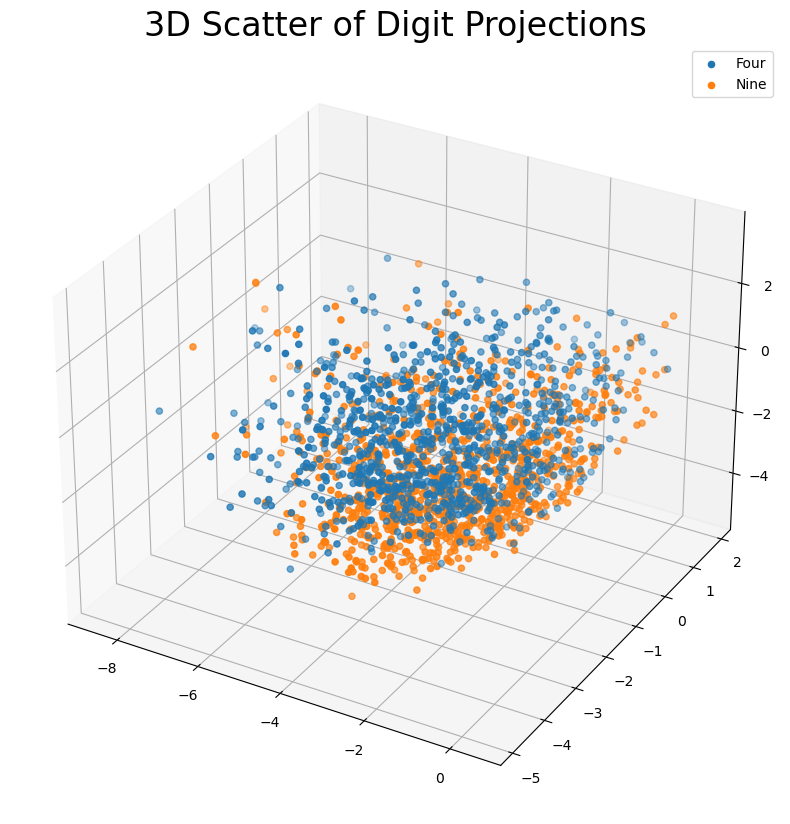

In [470]:
p0 = get_mnist_digitclass(0, kdim_proj_vecs, test_y)
p1 = get_mnist_digitclass(1, kdim_proj_vecs, test_y)
p2 = get_mnist_digitclass(2, kdim_proj_vecs, test_y)
p3 = get_mnist_digitclass(3, kdim_proj_vecs, test_y)
p4 = get_mnist_digitclass(4, kdim_proj_vecs, test_y)
p5 = get_mnist_digitclass(5, kdim_proj_vecs, test_y)
p6 = get_mnist_digitclass(6, kdim_proj_vecs, test_y)
p7 = get_mnist_digitclass(7, kdim_proj_vecs, test_y)
p8 = get_mnist_digitclass(8, kdim_proj_vecs, test_y)
p9 = get_mnist_digitclass(9, kdim_proj_vecs, test_y)

fig = figure(figsize=(10,10))

#p0_plot = scatter3D(p0[1, :], p0[2, :], p0[3, :], label = "Zero", s = 20)
# p1_plot = scatter3D(p1[1, :], p1[2, :], p1[3, :], label = "One", s = 20)
# p2_plot = scatter3D(p2[1, :], p2[2, :], p2[3, :], label = "Two", s = 20)
# p3_plot = scatter3D(p3[1, :], p3[2, :], p3[3, :], label = "Three", s = 20)
 p4_plot = scatter3D(p4[1, :], p4[2, :], p4[3, :], label = "Four", s = 20)
# p5_plot = scatter3D(p5[1, :], p5[2, :], p5[3, :], label = "Five", s = 20)
# p6_plot = scatter3D(p6[1, :], p6[2, :], p6[3, :], label = "Six", s = 20)
# p7_plot = scatter3D(p7[1, :], p7[2, :], p7[3, :], label = "Seven", s = 20)
# p8_plot = scatter3D(p8[1, :], p8[2, :], p8[3, :], label = "Eight", s = 20)
 p9_plot = scatter3D(p9[1, :], p9[2, :], p9[3, :], label = "Nine", s = 20)

title("3D Scatter of Digit Projections", size=24)
legend(loc="upper right")
PyPlot.savefig("3d-scatter-4-9.png")

### K-means clustering

In [282]:
function acc_score(pred, truth)
    score = 0
    for i = 1:length(pred)
        if(pred[i] == truth[i])
            score += 1
        end
    end
    
    return score / length(pred)
end

function get_corr_labels(arr, index)
    indexed_arr = Array{Float64}(undef, 0)

    for i = 1:length(arr)
        if index[i] == 1
            indexed_arr  = [indexed_arr; arr[i]]
        end
    end
    
    return indexed_arr
end

# gets most probable ground truth label corresponding to each bucket
# so that we know what cluster corresponds to what number
function get_cluster_assoc(cluster_labels, truth_labels)
    reference_labels = Dict()
    unique_labels = countmap(cluster_labels)
    
    for i = 1:length(unique_labels)
        index = [ifelse(x == i, 1, 0) for x in cluster_labels]
        indexed_truth_labels = get_corr_labels(truth_labels, index)
        
        counted_indexed_truth_labels = countmap(indexed_truth_labels)
        reference_labels[i] = findmax(counted_indexed_truth_labels)[2]
    end
    
    return reference_labels
end

get_cluster_assoc (generic function with 1 method)

### The code below performs the k-means clustering and prints out the dimensions of the projection matrix, the associated value with each clustering bin from our k-means, and the total accuracy our k-means clustering algorithm had

In [471]:
# perform actual k-means clustering
R = kmeans(kdim_proj_newcoords, 128; maxiter=500)
a = assignments(R)
c = counts(R)

# projection matrix dims 
println("Projections: " * string(size(kdim_proj_newcoords)))

# mappings between clustering bins and which number they represent
assoc_vals = get_cluster_assoc(a, test_y)
predicted_labels = [Int(assoc_vals[bin]) for bin in a]
println(assoc_vals)

println("Accuracy:         " * string(acc_score(predicted_labels, test_y)))

Projections: (16, 10000)
Dict{Any, Any}(5 => 1.0, 56 => 3.0, 35 => 2.0, 55 => 1.0, 110 => 5.0, 114 => 8.0, 123 => 8.0, 60 => 0.0, 30 => 2.0, 32 => 9.0, 6 => 2.0, 67 => 4.0, 45 => 8.0, 117 => 4.0, 73 => 6.0, 115 => 3.0, 112 => 3.0, 64 => 3.0, 90 => 8.0, 4 => 0.0, 13 => 3.0, 54 => 3.0, 63 => 0.0, 86 => 8.0, 104 => 9.0, 91 => 2.0, 62 => 6.0, 122 => 6.0, 58 => 5.0, 52 => 5.0, 12 => 3.0, 28 => 4.0, 75 => 7.0, 23 => 0.0, 111 => 0.0, 92 => 6.0, 41 => 7.0, 43 => 9.0, 11 => 4.0, 36 => 2.0, 68 => 2.0, 69 => 0.0, 98 => 0.0, 82 => 7.0, 85 => 6.0, 118 => 5.0, 119 => 9.0, 125 => 4.0, 39 => 5.0, 84 => 8.0, 77 => 5.0, 7 => 9.0, 25 => 9.0, 95 => 3.0, 126 => 1.0, 108 => 9.0, 71 => 8.0, 66 => 0.0, 76 => 2.0, 103 => 0.0, 34 => 7.0, 50 => 5.0, 59 => 5.0, 93 => 8.0, 2 => 8.0, 10 => 4.0, 18 => 4.0, 26 => 9.0, 27 => 3.0, 124 => 5.0, 42 => 2.0, 87 => 2.0, 127 => 0.0, 116 => 2.0, 100 => 4.0, 79 => 0.0, 16 => 2.0, 20 => 9.0, 81 => 0.0, 19 => 7.0, 49 => 0.0, 44 => 6.0, 9 => 3.0, 31 => 3.0, 74 => 3.0, 106 => 4.0, 

In [ ]:
# perform k-means with different bin sizes and plot accuracy as bin size increases

for i = 1:5:256
    
end

### Using our clustering bins from above, we can take the center of each bin and use its value to "reconstruct" what a generic digit from that bin looks like!

Kmeans Centers: (16, 128)


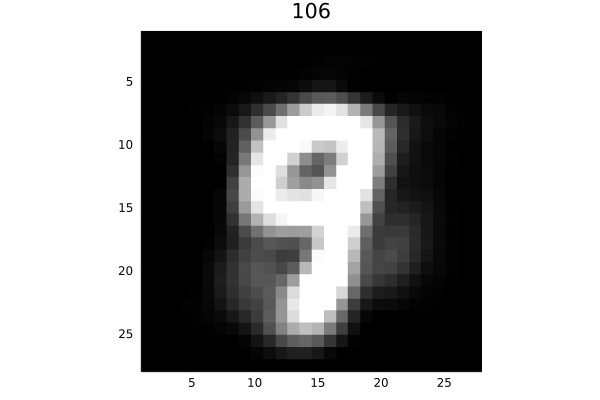

In [450]:
# transform k-means centers back to global coordinate frame
println("Kmeans Centers: " * string(size(R.centers)))
kmeans_center_images = reconstruct(pca_model, R.centers)

Plots.plot(show_sample_img(kmeans_center_images, 106))

In [ ]:
# p0 = get_mnist_digitclass(0, kdim_proj_vecs, test_y)
# p1 = get_mnist_digitclass(1, kdim_proj_vecs, test_y)
# p2 = get_mnist_digitclass(2, kdim_proj_vecs, test_y)
# p3 = get_mnist_digitclass(3, kdim_proj_vecs, test_y)
# p4 = get_mnist_digitclass(4, kdim_proj_vecs, test_y)
# p5 = get_mnist_digitclass(5, kdim_proj_vecs, test_y)
# p6 = get_mnist_digitclass(6, kdim_proj_vecs, test_y)
# p7 = get_mnist_digitclass(7, kdim_proj_vecs, test_y)
# p8 = get_mnist_digitclass(8, kdim_proj_vecs, test_y)
# p9 = get_mnist_digitclass(9, kdim_proj_vecs, test_y)

fig = figure(figsize=(20,20))

centers_plot = scatter3D(p0[1, :], p0[2, :], p0[3, :], label = "Zero", s = 20)

title("Julia Plots Like a Boss")
legend(loc="right")



### Here we add some random noise to the vector and show what our model outputs

(16, 128)

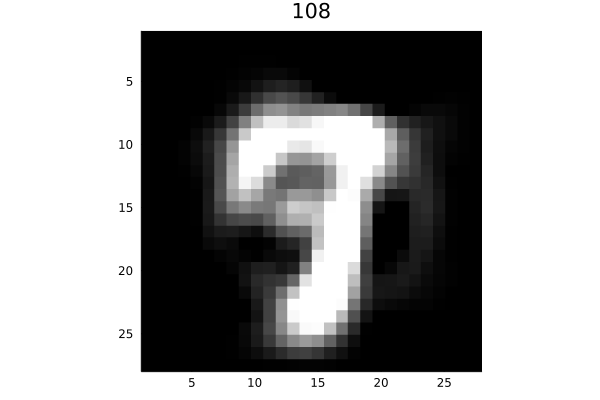

In [15]:
print(size(R.centers)) # embedding_dim dimensional vector

noisy_centers = add_gauss(R.centers, 0.9)

kmeans_noisy_centers = reconstruct(pca_model, noisy_centers)
Plots.plot(show_sample_img(kmeans_noisy_centers, 108))

This analyzes the dot product similarity between the centers of two clusters.
We use the centers of the bins representing the digits 9 and 4.
The two digits look somewhat similar, so we expect the centers to be somewhat similar 

In [16]:
function cosine_similarity(x, y)
    return dot(x, y) / (norm(x) * norm(y))
end

# now look at dot product similarity of cluster centers
println("Similarity of 9 and 4 center (cosine similarity): ")

c1 = R.centers[:, 106]
c2 = R.centers[:, 13]

println(cosine_similarity(c1, c2))

Similarity of 9 and 4 center (cosine similarity): 
0.6490950102410782


# THANKS FOR READING!
### For any questions: please email dkrajews@andrew.cmu.edu or mreich@andrew.cmu.edu